# Regresión lineal en Spark

Con el dataset de rentas de San Francisco limpio, implementamos nuestro primer modelo: una regresión lineal.

In [1]:
#--Variables globales
  #--data set limpio
INPUT_DATA = "/content/drive/MyDrive/data_sets/parquet/sf-airbnb-clean/"

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=14067b5c8b47fc49e090145973b9139448e8c58a1fdfe2ee72f9d2d73959727c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark

In [5]:
#--librearias a utilizar
import pyspark.sql.functions as F

from pyspark.ml.feature import (VectorAssembler,
                                OneHotEncoder,
                                StringIndexer,
                                RFormula)

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

Leemos el dataset que hemos limpiado

In [6]:
airbnbDF = spark.read.parquet(INPUT_DATA)
airbnbDF.show(3)

+-----------------+--------------------+----------------+-------------------------+----------------------+--------+----------+-------------+---------------+------------+---------+--------+----+--------+--------------+-----------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+-----+-----------+------------+-------+-----------------------+-------------------------+----------------------------+------------------------+------------------------------+-------------------------+----------------------+
|host_is_superhost| cancellation_policy|instant_bookable|host_total_listings_count|neighbourhood_cleansed|latitude| longitude|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|bed_type|minimum_nights|number_of_reviews|review_scores_rating|review_scores_accuracy|review_scores_cleanliness|review_scores_checkin|review_scores_communication|review_scores_location|

## Dividir el dataset en "train" y "test" sets

Debido a que el dataset es pequeño, vamos a seguir la conveción de dividir nuestro dataset en 80% de las muestras para el training set y el resto, 20%, para el testset.

__Nota__: Recuerden que cuando manejamos grandes datos, estos porcentajes pueden variar, teniendo como regla que 100,000 muestras son mas que suficiente para el testset

In [7]:
trainDF, testDF = airbnbDF.randomSplit([.8, .2], seed=42)

print(f"Tenemos {trainDF.cache().count()} muestras en el training set \
y {testDF.cache().count()} en el test set.")

Tenemos 5780 muestras en el training set y 1366 en el test set.


La partición anterior es una aproximación a los porcentajes elegidos y su variación se debe a como se realiazó el almacenamiento distribuido.

Otra fuente de variabilidad puede surgir si cambiemos el número de workers en nuestro cluster debido a que la partición del dataset original en los workers cambiará.

Para evitar estas fuentes de variabilidad se recomiendo guardar las particiones train y test en disco.

## Regresión lineal simple

Para iniciar vamos a utilizar un modelo muy sencillo de la forma:

$$price = \theta_0 + \theta_1 * bedrooms$$

Antes de iniciar, observamos nuestros datos antes de modelar:

In [8]:
(trainDF
  .select("price", "bedrooms")
  .summary()
  .show())

+-------+------------------+------------------+
|summary|             price|          bedrooms|
+-------+------------------+------------------+
|  count|              5780|              5780|
|   mean|214.47249134948098|              1.35|
| stddev| 325.8499109968376|0.9396893597086263|
|    min|              10.0|               0.0|
|    25%|             100.0|               1.0|
|    50%|             150.0|               1.0|
|    75%|             240.0|               2.0|
|    max|           10000.0|              14.0|
+-------+------------------+------------------+



Notamos dos cosas:
* Existen rentas que tienen 0 cuartos de dormir
* Existen rentas por 10,000 US la noche

Observando los datos anteriores pareciera que tenemos algunos "outliers". Lo debemos de tener en mente cuando analicemos los resultados finales.

Regresion lineal, tal como muchos otros algoritmos en Spark, requiere que todos los atributos esten contenidos en una sola columna, cuyos elementos sean vectores.

Para lograr esta transformación vamos a utilizar __VectorAssembler__

In [9]:
#--definimos nuestro objeto. Tenemos que especificar las columnas que se utilizaran como
#-atributos y el nombre de la columna donde se los acomodaremos
vecAssembler = VectorAssembler(inputCols=["bedrooms"],
                               outputCol="features")

#--aplicamos la transformación usando "transform"
vecTrainDF = vecAssembler\
            .transform(trainDF)

#--visulizamos el resultado
vecTrainDF\
    .select("bedrooms", "features", "price")\
    .show(3)

+--------+--------+-----+
|bedrooms|features|price|
+--------+--------+-----+
|     1.0|   [1.0]|200.0|
|     1.0|   [1.0]|130.0|
|     1.0|   [1.0]| 95.0|
+--------+--------+-----+
only showing top 3 rows



Estamos listos para realizar nuestra regresión lineal usando el estimador "LinearRegression", el resultado sera un transformador (lrModel) que puede ser utilizado para hacer predicciones:

In [10]:
#--definimos nuestro estimador
lr = LinearRegression(featuresCol="features",
                      labelCol="price")

#--lo entrenamos
lrModel = lr.fit(vecTrainDF)

Podemos inspeccionar el modelo, analizando sus coeficientes:

In [11]:
m = round(lrModel.coefficients[0], 2)
b = round(lrModel.intercept, 2)

print(f"El valor de las rentas se comporta como: precio = {m} x bedrooms + {b}")

El valor de las rentas se comporta como: precio = 123.68 x bedrooms + 47.51


### Pipelines

Para aplicar nuestro modelo en el "testset" debemos realizar las mismas transformaciones que hicimos en el training set.

En este caso en particular solo hicimos una transformación, la cual fue reorganizar nuestros atributos en un solo vector (VectorAssembler). Sin embargo, la mayoria de la veces se aplican varias transformaciones a los datos como:
* Estandarización
* Codificación: one-hot encoding
* Ingeniería de atributos
* Reducción de dimensiones: pca

Para organizar todas esas transformaciones existe el concepto de __Pipeline__, el cual concatena la aplicación de cada una de esas transformaciones de forma serial. De esta forma se reduce el código y se hace más comprensible.

In [12]:
#--definimos nuestro estimador especificando las acciones seriales que tiene que realizar,
#-en nuestro caso: 1. transformar los datos con vectorAssembler y despues hacer la regresión
pipeline = Pipeline(stages=[vecAssembler, lr])

#--entrenamos nuestro pipeline
pipelineModel = pipeline.fit(trainDF)

Finalmente podemos utilizar nuestro transformador "pipelineModel" para hacer predicciones:

In [13]:
predDF = pipelineModel.transform(testDF)

(predDF
    .select("bedrooms",
            "features",
            "price",
            F.round("prediction",2))
    .show(10))

+--------+--------+------+--------------------+
|bedrooms|features| price|round(prediction, 2)|
+--------+--------+------+--------------------+
|     1.0|   [1.0]|  85.0|              171.19|
|     1.0|   [1.0]|  45.0|              171.19|
|     1.0|   [1.0]|  70.0|              171.19|
|     1.0|   [1.0]| 128.0|              171.19|
|     1.0|   [1.0]| 159.0|              171.19|
|     2.0|   [2.0]| 250.0|              294.86|
|     1.0|   [1.0]|  99.0|              171.19|
|     1.0|   [1.0]|  95.0|              171.19|
|     1.0|   [1.0]| 100.0|              171.19|
|     1.0|   [1.0]|2010.0|              171.19|
+--------+--------+------+--------------------+
only showing top 10 rows



## Regresion lineal multiple

En este ejemplo vamos a expandir el modelo de regresión lineal para que utilice todas las variables númericas y también las categóricas (string variables).

Para utilizar las variables categóricas debemos convertirlas en numéricas debido a que la mayoría de algoritmos de ML esperan solo atributos númericos. Una forma de hacerlo es recodificarlas usando "one hot encoding" (OHE). Existen dos métodos para obtener la codificación OHE.

### Método 1 para OHE:
Se realiza en dos pasos:
1. StringIndexer: utilizado para convertir variables categóricas de texto en variables categóricas númericas.
2. OneHotEncoder: utiliza las variables categóricas númericas para realizar la codificación

In [14]:
#--tenemos que encontrar todas las columnas que son de texto
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]

#--creamos nombres para las columnas de salida
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#--convertimos las variables de texto en variables categóricas numéricas
stringIndexer = StringIndexer(inputCols=categoricalCols,
                              outputCols=indexOutputCols,
                              #--controla las categorías que pudieran aparecer en el test set
                              #-y que no se hayan definidos en el training set. Hay tres opciones
                              #-"skip": remueve esa muestra
                              #-"error": termina el proceso con mensaje de error
                              #-"keep": crea una nueva categoría
                              handleInvalid="skip")

#--aplicas el one hot encoding
oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                           outputCols=oheOutputCols)

Combinamos las nuevas variables (OHE) con nuestro dataset

In [15]:
#--encontramos todas las columnas númericas que no sean "price"
numericCols = [field for (field, dataType) in trainDF.dtypes if ((dataType == "double") & (field != "price"))]

#--concatemos
assemblerInputs = oheOutputCols + numericCols

#--juntamos todos los atributos en un solo vector
vecAssembler = VectorAssembler(inputCols=assemblerInputs,
                               outputCol="features")

Una desventaja de este método es que tenemos que especificar todas las columnas que deseamos codificar, puede haber columnas categóricas que no sean de texto sino númericas.


### Método 2 para OHE:

La otra opción es utilizar el método __RFormula__, el cual sigue la sintaxis de las formulas en R para especificar el modelo. Una vez definido el modelo, RFormula automaticamente convierte todos los atributos de texto a one-hot cnecoding, convierte todas las columnas númericas a dobles y combina todos los atributos en una sola columna (VectorAssember).

Símbolos usados en __RFormula__:

&nbsp;&nbsp;&nbsp;__~__    Indica dependencia, e.g. y ~ x, y depende de x. Separa variable respuesta de sus predictores.

&nbsp;&nbsp;&nbsp;__+__    Concatena predictores

&nbsp;&nbsp;&nbsp;__.__    Inluye todas las columnas excepto la variable respuesta.

&nbsp;&nbsp;&nbsp;__-__    Remueve un termino o predcitor. Por ejemplo "-1" indica que no queremos intercept, ". - bedrooms" incluye todos los predictores menos "bedrooms".

&nbsp;&nbsp;&nbsp;__:__    intereacción entre dos variables, e.g. "y ~ x1 + x2 + x1:x2"

In [16]:
rFormula = RFormula(formula="price ~ .", # formula = "bedrooms + host_is_superhost"
                    #--nombre de la columna donde se encuentran los predictores
                    featuresCol="features",
                    #--nombre de la columna con la variable respuesta
                    labelCol="price",
                    #--que hacer con categorías no vistas en el training set
                    handleInvalid="skip")

La desventaja de RFormula es que no siempre se requiere un one-hot encoding de las variables categoricas. Por ejemplo, los algoritmos basados en árboles pueden manejar directamente variables categóricas.

Ahora pondremos todo dentro de una pipeline para entrenar el modelo.

In [17]:
#--definimos nuestro estimador para la regresión lineal
lr = LinearRegression(labelCol="price",
                      featuresCol="features")

Modelo utilizando el método 1 para codificar variables categóricas:

In [18]:
#--definimos el estimador pipeline
pipeline = Pipeline(stages=[stringIndexer,
                            oheEncoder,
                            vecAssembler,
                            lr])

#--lo entrenamos
pipelineModel = pipeline.fit(trainDF)

#--hacemos predicciones en con el testset
predDF = pipelineModel.transform(testDF)
predDF.select("features",
              "price",
              F.round("prediction",2)).show(5)

+--------------------+-----+--------------------+
|            features|price|round(prediction, 2)|
+--------------------+-----+--------------------+
|(98,[0,3,6,22,43,...| 85.0|               55.71|
|(98,[0,3,6,22,43,...| 45.0|               23.11|
|(98,[0,3,6,22,43,...| 70.0|               27.64|
|(98,[0,3,6,12,42,...|128.0|               -92.4|
|(98,[0,3,6,12,43,...|159.0|               94.85|
+--------------------+-----+--------------------+
only showing top 5 rows



Utilizando método 2 (RFormula) para codificar las variables categçoricas:

In [19]:
#--al definir el estimador pipeline solo tenemos que definir la formula y el estimador de regression
pipeline = Pipeline(stages = [rFormula,
                              lr])

#--entrenamos
pipelineModel = pipeline.fit(trainDF)

#--hacemos predicciones con el testset
predDF = pipelineModel.transform(testDF)
predDF.select("features",
              "price",
              F.round("prediction",2)).show(5)

+--------------------+-----+--------------------+
|            features|price|round(prediction, 2)|
+--------------------+-----+--------------------+
|(98,[0,3,6,7,23,4...| 85.0|                55.3|
|(98,[0,3,6,7,23,4...| 45.0|               22.71|
|(98,[0,3,6,7,23,4...| 70.0|               27.18|
|(98,[0,3,6,7,13,4...|128.0|              -91.91|
|(98,[0,3,6,7,13,4...|159.0|               94.54|
+--------------------+-----+--------------------+
only showing top 5 rows



## Evaluación de nuestro modelo

Dado que estamos trabajando con una regresión vamos a utilizar dos métricas para medir que tan bien esta ajustando nuestro modelo a los datos:

* RMSE
* $R^2$

In [20]:
#--especificamos las columnas que contiene la predicción y el valor verdarero, además
#-indicamos que deseamos calcular el rmse
regressionEvaluator = RegressionEvaluator(predictionCol="prediction",
                                          labelCol="price",
                                          metricName="rmse")

#--ejecutamos el calculo pasando como argumento de entrada el dataframe que tiene las predicciones
rmse = round(regressionEvaluator.evaluate(predDF), 2)
print(f"RMSE: {rmse}")

RMSE: 220.64


¿Qué tan bueno o malo es equivocarse en promedio por 220.62 dólares?, en otras palabras ¿Qué tan bueno es nuestro modelo?

Para responder a la pregunta anterior, necesitamos comparar nuestro algoritmo con un "modelo base". En el caso de regresión un modelo base comunmente utilizado es predecir siempre la media.

In [21]:
#-lit: crea un columna con el valor que se le da
#--calculamos el precio promedio
avgPrice= trainDF.select(F.avg("price")).first()[0]

#--agregamos una columna que contiene en todas las filas el valor promedio
predDF_base = testDF.withColumn("avgPrediction", F.lit(avgPrice))

#--calculamos el RMSE con respecto al promedio
regressionMeanEvaluator = RegressionEvaluator(predictionCol="avgPrediction",
                                              labelCol="price",
                                              metricName="rmse")

print(f"RMSE para el precio promedio es: {regressionMeanEvaluator.evaluate(predDF_base):.2f}")

RMSE para el precio promedio es: 240.71


In [22]:
#--utilizando el mismo estimador que antes, cambiamos la métrica a evaluar
regressionEvaluator = RegressionEvaluator(predictionCol="prediction",
                                          labelCol="price",
                                          metricName="r2")

r2 = round(regressionEvaluator.evaluate(predDF), 2)
print(f"R2: {r2}")

R2: 0.16


Una vez terminado el proceso, podemos guardar el modelo para su uso en el futuro.

Cuando volvemos a cargar el modelo necesitamos especificar que tipo de "estimador" es, por eso es aconsejable utilizar pipelines para que siempre mandemos a cargar estimadores del tipo pipeline independiente del modelo de ML usado.

In [23]:
#--como guardar y volver a cargar nuestros modelos
#-guardar
pipelinePath = "/content/drive/MyDrive/data_sets/modelos/"
pipelineModel.write().overwrite().save(pipelinePath)

#-leer
from pyspark.ml import PipelineModel
savedPipelineModel = PipelineModel.load(pipelinePath)

## Ejercicio

Al plotear la distribución de la variable respuesta vemos lo siguiente:

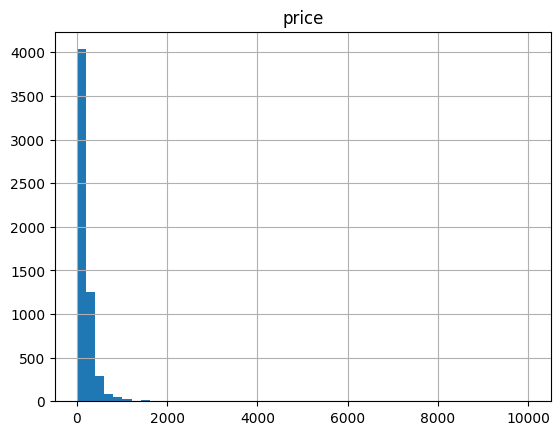

In [24]:
y = (trainDF
      .select('price')
      .toPandas())

y.hist(bins=50);

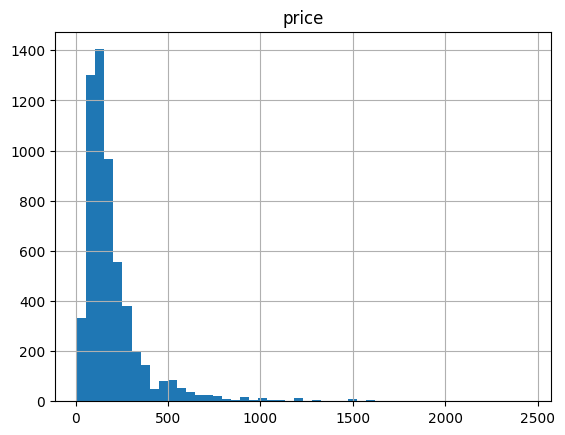

In [25]:
y[y['price']<3000].hist(bins=50);

¿Qué podemos hacer?

In [ ]:
spark.stop()